# DAMP: Discord-Aware Matrix Profile

Authors in [DAMP](https://www.cs.ucr.edu/~eamonn/DAMP_long_version.pdf) presented a method for discord detection that is scalable and it can be used in offline and online mode.

To better understand the mechanism behind this method, we should first understand the difference between the full matrix profile and the left matrix profile of a time series `T`. For a subsequence with length `m`, and the start index `i`, i.e. `S_i = T[i:i+m]`, there are two groups of neighbors, known as left and right neighbors. The left neighbors are the subsequences on the left side of `S_i`, i.e. the subsequences in `T[:i]`. And, the right neighbors are the subsequences on the right side of `S_i`, i.e. the subsequences in `T[i+1:]`. The `i`-th element of the full matrix profile is the minimum distance between `S_i` and all of its neighbors, considering both left and right ones. However, in the left matrix profile, the `i`-th element is the minimum distance between the subsequence `S_i` and its left neighbors.

One can use either the full matrix profile or the left matrix profile to find the top discord, a subsequence whose distance to its nearest neighbor is larger than the distance of any other subsequences to their nearest neighbors. However, using full matrix profile for detecting discords might result in missing the case where there are two rare subsequences that happen to also be similar to each other (a case that is known as "twin freak"). On the other hand, the left matrix profile resolves this problem by capturing the discord at its first occurance. Hence, even if there are two or more of such discords, we can still capture the first occurance by using the left matrix profile.

For now, let us consider a time series `T` and let's say we are interested in finding the top discord in an offline/batch setting. Suppose a time series `T` is set as follows:

In [6]:
T = [
    0, 
    1, 
    2, 
    1000, 
    2000, 
    3000, 
    100, 
    101, 
    102, 
    0.1, 
    1.1, 
    2.1, 
    1000.1, 
    2000.1, 
    3000.1, 
    100.1, 
    101.1, 
    102.1, 
    0, 
    2000, 
    0,
]

Also suppose that we are interested in subsequences with length `m=3` and we want to compare them with Euclidean distance. Let's start with the very first subsequence, i.e. `[0, 1, 2]`. Can we say if it is a discord or not? 

The answer is: No, we cannot! This is because we have not obtained any information about the regular behaviors in the system yet. Furthermore, there is no historical data (subsequences) that can be used as our reference. As we slide the window to the right, we observe more data and we can better understand the regular patterns. When we reach the subsequence `[1000, 1001, 1002]`, we might think that this is the discord. However, that is not true  as we have the similar pattern `[1000.1, 1001.1, 1002.1]` that appears later in the data. 

**Now the question is:** What can be done to avoid selecting wrong discord?

One way to resolve this is to consider the first few points in `T` as training, and we start discovering discords (potential anomalies) for the remaining points. Hence, for a given `split_idx`, the train part is `T[:split_idx]` and the potential anomalies should be coming from `T[split_idx:]`. The value of `split_idx` is problem dependent. If `split_idx` is too small, then `T[:split_idx]` may not contain all different kinds of regular patterns. Hence, we may incorrectly select a subsequence as a discord. If `split_idx` is too large, we may miss a discord if that discord and its nearest neighbor are both in `T[:split_idx]`. 

Later in this notebook, an alternative approach will be provided that does not need the `split_idx`. However, the user still needs to provide the regular patterns of the system first. For now, we consider `split_idx` in the implementation so as to remain faithful to the paper's implementation regarding classic DAMP.

# Getting Started

## core idea

**How to find the top discord of `T` in the offline/batch mode?**<br> 
To find the top discord, one can compute the left matrix profile, PL, and locate the index i where PL has the maximum finite value. The discord is the subsequence located at index i, i.e. the subsequence `T[i:i+m]`. What `DAMP` does is that it computes an approximate left matrix profile whose maximum is exact! This means that it can still give us the correct discord.

**How does DAMP work?**<br>
Let's say we have a time series `T` and we begin checking each subsequence starting from left to right and updating our best-so-far discord as a rarer, more unique subsequence is encountered. At the `i`-th subsequence, the distance for the best-so-far discord is simply the distance between the rarest/most unique subsequence, discovered somewhere amongst `T[:i]`, and its [exact] left nearest neighbor. Let's denote the best-so-far discord distance as `bsf`. Naively, one can compare `S_i` with all of its left neighbors, i.e. the subsequences in `T[:i]`, and find its one-nearest-neighbor. However, this is very time consuming and DAMP employs an early abandoning approach that helps to dramatically reduce this computational time. So, as soon as DAMP finds a left neighbor whose distance to `S_i` is less than the best-so-far distance `bsf`, `DAMP` stops exploring the remaining of the left neighbors because the distance between `S_i` to its left nearest neighbor would also be less than `bsf`, which means `S_i` cannot take the top-discord place. This is called **BackwardProcessing**. To take advantage of rolling-based computation, the "BackwardProcessing" explores the left neighbors of `S_i` chunk by chunk, and use the MASS algorithm to compute the distance between `S_i` and the subsequences in each chunk. If we cannot find a subsequence whose distance to `S_i` is less than `bsf`, we go to the next chunk, and we update the distance between `S_i` and its best-so-far-discovered 1NN, `S_nn_i`. If we exhaust the subsequences in all the chunks and realize that the distance between `S_i` and `S_nn_i` is greater than `bsf`, then we update `bsf`. In such case, the subsequence `S_i` becomes the best-so-far discord and `bsf` is the distance between the best-so-far discord and its nearest neighbor.

We can now go to the next index, i.e. `i+1`, and do the same process. That means, for the next subsequence, we need to run "BackwardProcessing" at least once, i.e. using MASS algorithm to compute the distance between the subsequence `T[i+1:i+1+m]` and the subsequences in [at least] one chunk. But... what if we can find a way to prune some of the forthcoming subsequences? Then, we only need to do "BackwardProcessing" for the ones that are not pruned! This can speed up the process in discovering the top discord. To prune the forthcoming subsequences, we can use MASS to compute the distance between `S_i` and its right neighbors. This is known as **ForwardProcessing**. Note that for those subsequences, `S_i` is considered as one of their left neighbors! So, if the distance between `S_i` and any one of those subsequences become less than `bsf`, those subsequences can be prunned. Therefore, when `DAMP`'s process reaches one of those pruned subsequences, the "BackwardProcessing" can just be skipped as we already know that the subsequence is already pruned and cannot be the top discord.

In [7]:
import math

import numpy as np
import matplotlib.pyplot as plt
import stumpy
import time

from stumpy import core
from scipy.io import loadmat

## Naive approach

In [8]:
def naive_DAMP(T, m, split_idx):
    """
    Compute the top discord in `T`, where the subsequence discord resides in T[split_index:]
    
    Parameters
    ----------
    T : numpy.ndarray
        A time series for which the top discord will be computed.
        
    m : int
        Window size
    
    split_idx : int
        The split index between train and test. See note below for further details.
    
    Returns
    -------
    PL : numpy.ndarry
        The [exact] left matrix profile. All infinite distances are ingored in computing
        the discord.
        
    discord_dist : float
        The discord's distance, which is the distance between the top discord and its
        left nearest neighbor
        
    discord_idx : int
        The start index of the top discord
        
    Note
    ----
    
    """
    excl_zone = int(np.ceil(m / stumpy.config.STUMPY_EXCL_ZONE_DENOM))
    
    mp = stumpy.stump(T, m)
    IL = mp[:, 2].astype(np.int64)
    IL[:split_idx] = -1  # `split_idx` or `split_idx-m`?
    
    PL = np.full_like(IL, np.inf, dtype=np.float64)
    for i, nn_i in enumerate(IL):
        if nn_i >= 0:
            PL[i] = np.linalg.norm(core.z_norm(T[i : i + m]) - core.z_norm(T[nn_i : nn_i + m]))
    
    PL_modified = np.where(PL==np.inf, np.NINF, PL)
    discord_idx = np.argmax(PL_modified)
    discord_dist = PL_modified[discord_idx]
    if discord_dist == np.NINF:
        discord_idx = -1
        
    return PL, discord_dist, discord_idx

In [9]:
seed = 100
np.random.seed(seed)

T = np.random.rand(100000)
m = 50
split_index = 200

naive_DAMP(T, m, split_index)  # dummy run
t_start = time.time()
excl_zone_denom = core.config.STUMPY_EXCL_ZONE_DENOM
core.config.STUMPY_EXCL_ZONE_DENOM = 1.0
PL, discord_dist, discord_index = naive_DAMP(T, m, split_index)
core.config.STUMPY_EXCL_ZONE_DENOM = excl_zone_denom
t_end = time.time()

print('discord_dist: ', discord_dist)
print('discord_index: ', discord_index)
print('running time [sec]: ', t_end - t_start)

discord_dist:  8.500883427933502
discord_index:  209
running time [sec]:  8.3678457736969


## DAMP approach

In [32]:
def next_pow2(v):
    """
    Compute the smallest "power of two" number that is greater than/ equal to `v`
    
    Parameters
    ----------
    v : float
        A real positive value
    
    Returns
    -------
    out : int
        An integer value that is power of two, and satisfies `out >= v`
    """
    return int(math.pow(2, math.ceil(math.log2(v))))

In [12]:
def _backward_process(
    T, 
    m, 
    query_idx, 
    M_T, 
    Σ_T, 
    T_subseq_isconstant, 
    excl_zone, 
    bsf,
):
    """
    Compute the approximate left matrix profile value that corresponds to the subsequence 
    `T[query_idx:query_idx+m]` and update the best-so-far discord distance.
    
    Parameters
    ----------
    T : numpy.ndarray
        A time series
    
    m : int
        Window size
    
    query_idx : int
        The start index of the query with length `m`
    
    M_T : np.ndarray
        The sliding mean of `T`
        
    Σ_T : np.ndarray
        The sliding standard deviation of `T`
    
    T_subseq_isconstant : numpy.ndarray
        A numpy boolean array whose i-th element indicates whether the subsequence
        `T[i : i+m]` is constant (True)
    
    excl_zone : int
        exclusion zone
    
    bsf : float
        The best-so-far discord distance
        
    Returns
    -------
    distance : float
        The [approximate] left matrix profile value that corresponds to 
        the query, `T[query_idx : query_idx + m]`.
    
    bsf : float
        The best-so-far discord distance 
    """
    # initializing the best-so-far nearest-neighbor distance of 
    # the query `Q = T[query_idx : query_idx + m]`
    nn_distance = np.inf  
    
    chunksize = next_pow2(m) 
    chunk_stop = (query_idx - excl_zone) + m  
    chunk_start = max(0, chunk_stop - chunksize)
    
    while nn_distance >= bsf:
        QT = core.sliding_dot_product(
            T[query_idx : query_idx + m], 
            T[chunk_start : chunk_stop],
        )
        D = core._mass(
            T[query_idx : query_idx + m],
            T[chunk_start : chunk_stop],
            QT=QT,
            μ_Q=M_T[query_idx],
            σ_Q=Σ_T[query_idx],
            M_T=M_T[chunk_start : chunk_stop - m + 1],
            Σ_T=Σ_T[chunk_start : chunk_stop - m + 1],
            Q_subseq_isconstant=T_subseq_isconstant[query_idx],
            T_subseq_isconstant=T_subseq_isconstant[chunk_start : chunk_stop - m + 1],
            )
        
        nn_distance = min(nn_distance, np.min(D))    
        
        if chunk_start == 0:  # all chunks are visited.
            bsf = max(bsf, nn_distance)
            break
        
        chunksize = 2 * chunksize
        chunk_stop = chunk_start + m
        chunk_start = max(0, chunk_stop - chunksize)
    
    return nn_distance, bsf


def _foreward_process(
    T, 
    m,  
    M_T, 
    Σ_T, 
    T_subseq_isconstant, 
    excl_zone, 
    query_idx, 
    bsf, 
    pruned,
):
    """
    Update the boolean array `pruned`, in place, by pruning subsequences that appear
    after `query_idx` in the data `T`, and their distance to `T[query_idx : query_idx + m]`
    is less than `bsf`.
    
    Paramaters
    ----------
    T : numpy.ndarray
        The time series or sequence for which the top discord will be computed.
    
    m : int
        Window size
        
    M_T : numpy.ndarray
        The sliding mean
        
    Σ_T : numpy.ndarray
        The sliding standard deviation
        
    T_subseq_isconstant : numpy.ndarray
        A numpy boolean array whose i-th element indicates whether the subsequence
        `T[i : i+m]` is constant (True)
    
    excl_zone : int
        exclusion zone
    
    query_idx : int
        The start index of the subsequence of interest
    
    bsf : float
        The best-so-far discord distance
        
    pruned : np.ndarray
        A boolean numpy array that indicate whether a subsequence is pruned for
        being considered as discord
        
    Returns
    -------
    None
    """    
    chunksize = next_pow2(m)  
    chunk_start = query_idx + excl_zone + 1
    chunk_stop = min(chunk_start + chunksize, len(T))
    if chunk_stop - chunk_start >= m:
        QT = core.sliding_dot_product(T[query_idx : query_idx + m], T[chunk_start : chunk_stop])
        D = core._mass(
            T[query_idx : query_idx + m],
            T[chunk_start : chunk_stop],
            QT=QT,
            μ_Q=M_T[query_idx],
            σ_Q=Σ_T[query_idx],
            M_T=M_T[chunk_start : chunk_stop - m + 1],
            Σ_T=Σ_T[chunk_start : chunk_stop - m + 1],
            Q_subseq_isconstant=T_subseq_isconstant[query_idx],
            T_subseq_isconstant=T_subseq_isconstant[chunk_start : chunk_stop - m + 1],
        )
        
        mask = np.argwhere(D < bsf) + chunk_start
        pruned[mask] = True

    return

        
                
def DAMP(T, m, split_idx):  # Add param `T_subseq_isconstant`  
    """
    Compute the approximate left matrix profile for `T`. The global maximum
    of this approximate profile is exact.
    
    Parameters
    ----------
    T : numpy.ndarray
        A time series
    
    m : int
        Window size
    
    split_idx : int
        location of split point between train and test. The data `T[:split_idx]`
        is considered as train and the remaining, i.e. `T[split_idx:]` is test.
    
    Returns
    -------
    PL : numpy.ndarry
        The approximate left matrix profile. All infinite distances are ingored in computing
        the discord. The global maximum of `PL` is exact, and indicates the discord.
        
    discord_dist : float
        The distance between the discord and its nearest neighbor
        
    discord_idx : int
        The start index of discord
    """
    T, M_T, Σ_T, T_subseq_isconstant = core.preprocess(T, m)
    excl_zone = int(np.ceil(m / stumpy.config.STUMPY_EXCL_ZONE_DENOM))
    
    l = len(T) - m + 1
    PL = np.full(l, np.inf, dtype=np.float64) 
    pruned = np.full(l, 0, dtype=bool)
    
    bsf = np.NINF  # the best-so-far discord distance
    for i in range(split_idx, l):
        if pruned[i]:
            PL[i] = PL[i-1]
        else:
            PL[i], bsf = _backward_process(T, m, i, M_T, Σ_T, T_subseq_isconstant, excl_zone, bsf)
            _foreward_process(T, m, M_T, Σ_T, T_subseq_isconstant, excl_zone, i, bsf, pruned)

    P = np.where(PL==np.inf, np.NINF, PL)
    discord_idx = np.argmax(P)
    discord_dist = P[discord_idx]
    if discord_dist == np.NINF:
        discord_idx = -1
        
    return PL, discord_dist, discord_idx

In [13]:
DAMP(T, m, split_index)  # dummpy run
t_start = time.time()
excl_zone_denom = core.config.STUMPY_EXCL_ZONE_DENOM
core.config.STUMPY_EXCL_ZONE_DENOM = 1
PL, discord_score, discord_idx = DAMP(T, m, split_index)
core.config.STUMPY_EXCL_ZONE_DENOM = excl_zone_denom
t_end = time.time()

print('discord value: ', discord_score)
print('discord at index: ', discord_idx)
print('running time [sec]: ', t_end - t_start)

discord value:  8.500883427933504
discord at index:  209
running time [sec]:  2.533235788345337


# Reproducing Fig. 3 of paper (Anomaly in ECG data)

In [14]:
data = loadmat("DAMP_data/A_60-second snippet of an ECG.mat") 
T = data['val'].flatten().astype(np.float64)

print(f"T has length: {len(T)}")

T has length: 30000


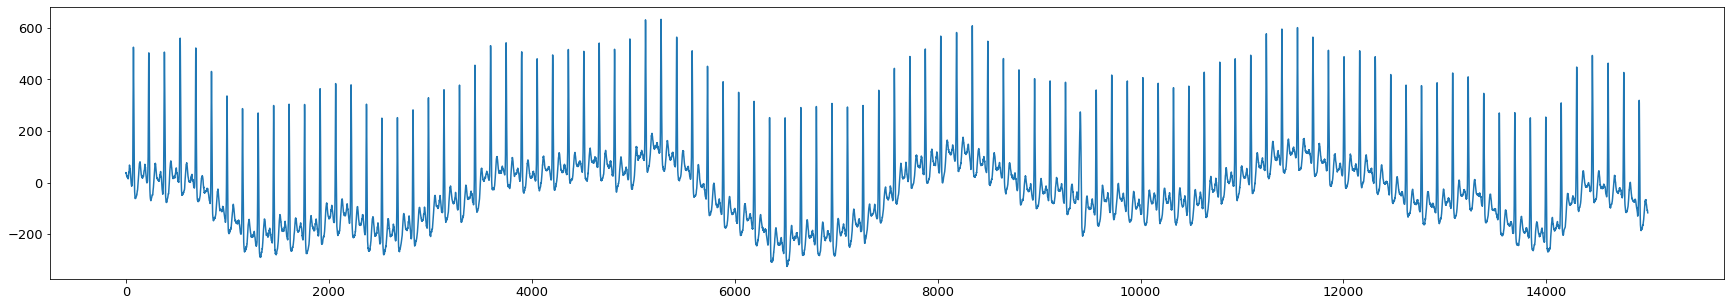

In [15]:
T = T[:15000] # similar to the length considered in the paper
plt.figure(figsize=(30, 5))
plt.plot(T)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

As observed, it is hard to locate the anomaly. Let's find it.

In [16]:
# `m` is provided in the supporting webpage. 
# see: https://sites.google.com/view/discord-aware-matrix-profile/reproducibility?authuser=0
m = 150   
split_idx = 500  # rough value based on visual inspection of figure in the paper

t_start = time.time()
excl_zone_denom = core.config.STUMPY_EXCL_ZONE_DENOM
core.config.STUMPY_EXCL_ZONE_DENOM = 1.0
PL_ref, discord_dist_ref, discord_idx_ref = naive_DAMP(T, m, split_idx)
core.config.STUMPY_EXCL_ZONE_DENOM = excl_zone_denom
t_end = time.time()

print('discord_dist: ', discord_dist_ref)
print('discord_index: ', discord_idx_ref)
print('running time: [sec]: ', t_end - t_start)

discord_dist:  7.774100500490462
discord_index:  9262
running time: [sec]:  0.7130470275878906


In [17]:
t_start = time.time()
excl_zone_denom = core.config.STUMPY_EXCL_ZONE_DENOM
core.config.STUMPY_EXCL_ZONE_DENOM = 1.0
PL_comp, discord_dist_comp, discord_idx_comp = DAMP(T, m, split_idx)
core.config.STUMPY_EXCL_ZONE_DENOM = excl_zone_denom
t_end = time.time()

print('discord_dist: ', discord_dist_comp)
print('discord_index: ', discord_idx_comp)
print('running time: [sec]: ', t_end - t_start)

discord_dist:  7.7741005004904595
discord_index:  9262
running time: [sec]:  0.42067623138427734


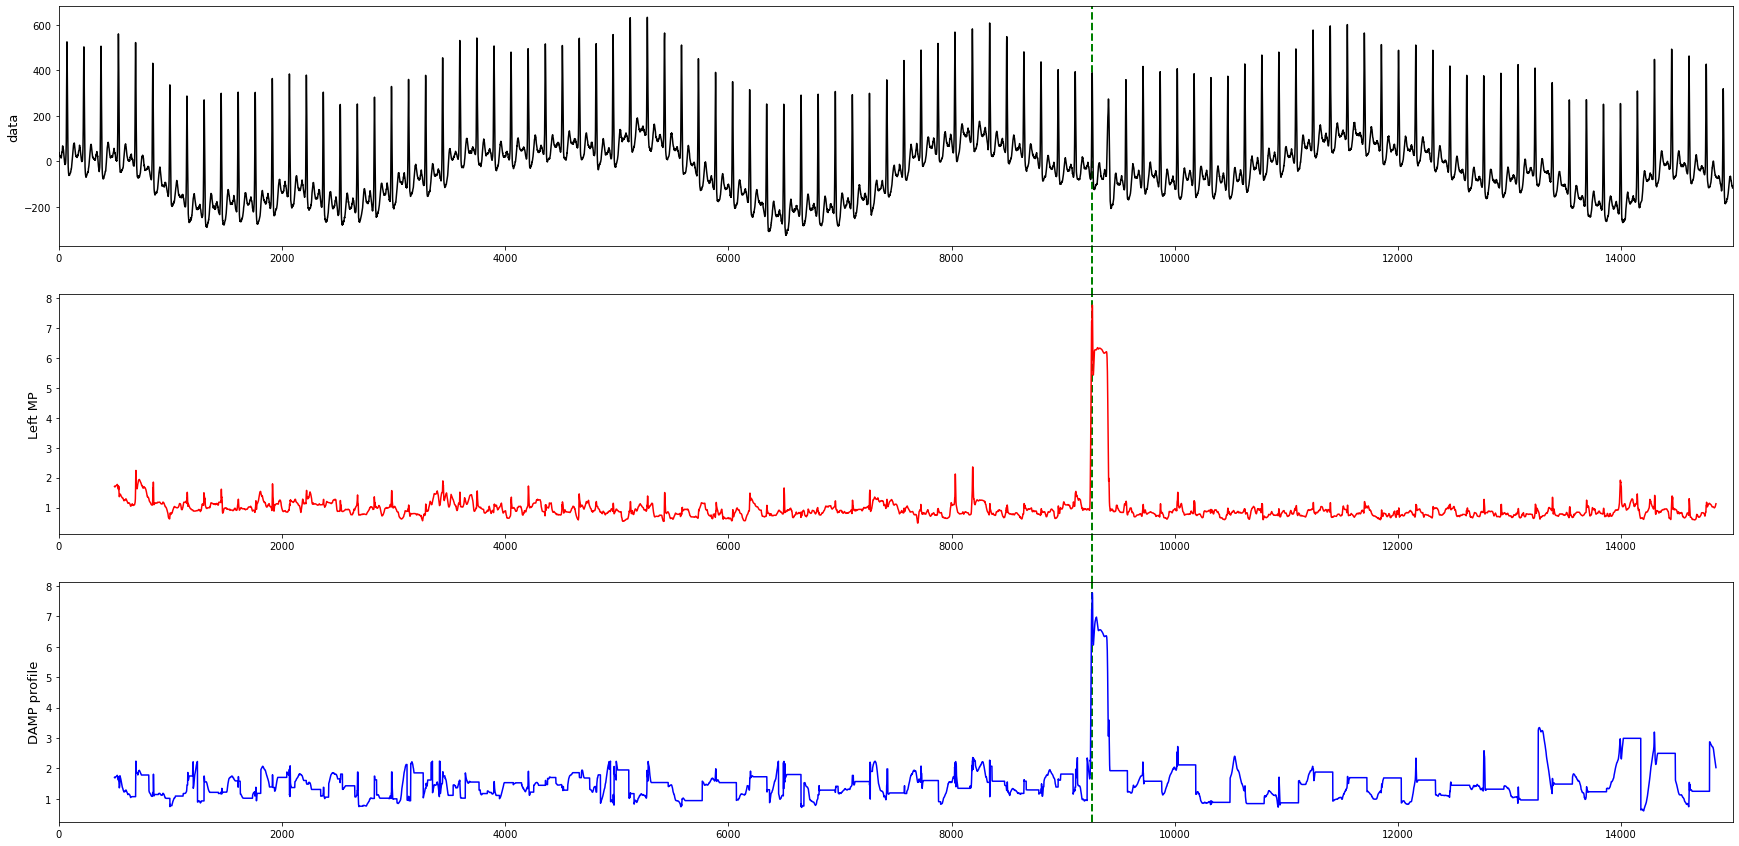

In [18]:
fig, axs = plt.subplots(nrows=3, figsize=(30, 15))

axs[0].plot(T, color='k')
axs[0].set_xlim(0, 15000)

axs[1].plot(PL_ref, color='r')
axs[1].set_xlim(0, 15000)

axs[2].plot(PL_comp, color='b')
axs[2].set_xlim(0, 15000)

axs[0].axvline(x=discord_idx_comp,ymin=-1,ymax=1,c="g",linewidth=2, linestyle='--', zorder=0, clip_on=False)
axs[1].axvline(x=discord_idx_comp,ymin=-1,ymax=1,c="g",linewidth=2, linestyle='--', zorder=0, clip_on=False)
axs[2].axvline(x=discord_idx_comp,ymin=0,ymax=1,c="g",linewidth=2, linestyle='--', zorder=0, clip_on=False)

axs[0].set_ylabel('data', fontsize=13)
axs[1].set_ylabel('Left MP', fontsize=13)
axs[2].set_ylabel('DAMP profile', fontsize=13)

plt.show()

As observed, the global maximum of `DAMP profile` is exact and that is enough to get the top-1 discord.

## Reproducing Fig. 2 of paper (Anomaly in electrical motor data)

In [25]:
data = loadmat("DAMP_data/bearing_time_series.mat") 
T = data['testdata'].flatten().astype(np.float64)

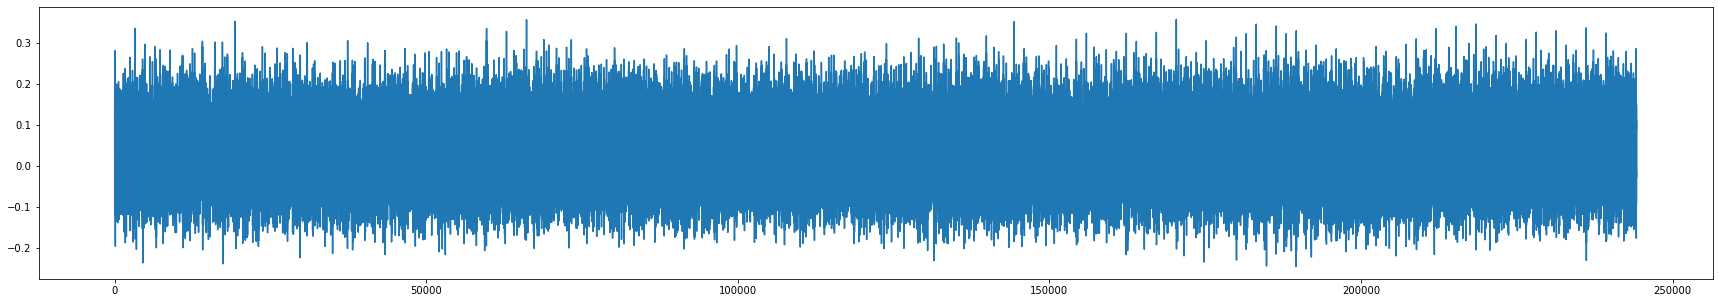

In [26]:
plt.figure(figsize=(30, 5))
plt.plot(T)
plt.show()

In [27]:
print(f'length of `T`: {len(T)}')

length of `T`: 244189


In [28]:
# setting the parameters
m = 300  # according to supporting page
split_idx = 5000  # rough value based on visual inspection of figure in the paper

In [29]:
# naive
t_start = time.time()
excl_zone_denom = core.config.STUMPY_EXCL_ZONE_DENOM
core.config.STUMPY_EXCL_ZONE_DENOM = 1.0
PL_ref, discord_dist_ref, discord_idx_ref = naive_DAMP(T, m, split_idx)
core.config.STUMPY_EXCL_ZONE_DENOM = excl_zone_denom
t_end = time.time()

print('discord_dist: ', discord_dist_ref)
print('discord_index: ', discord_idx_ref)
print('running time: [sec]: ', t_end - t_start)

discord_dist:  16.925815600199474
discord_index:  49881
running time: [sec]:  40.74179983139038


In [30]:
# performant 
t_start = time.time()
excl_zone_denom = core.config.STUMPY_EXCL_ZONE_DENOM
core.config.STUMPY_EXCL_ZONE_DENOM = 1.0
PL, discord_dist, discord_idx = DAMP(T, m, split_idx)
core.config.STUMPY_EXCL_ZONE_DENOM = excl_zone_denom
t_end = time.time()

print('discord_dist: ', discord_dist)
print('discord_index: ', discord_idx)
print('running time [sec]: ', t_end - t_start)

discord_dist:  16.92581560019947
discord_index:  49881
running time [sec]:  30.72162890434265


The computed index `49881` matches the index provided in the supporting webpage. <br>
see [this slide of powerpoint](https://docs.google.com/presentation/d/1tQQfKuKrOa3j5-WJ9peoYfZGOnJbBcl9/edit#slide=id.p35)

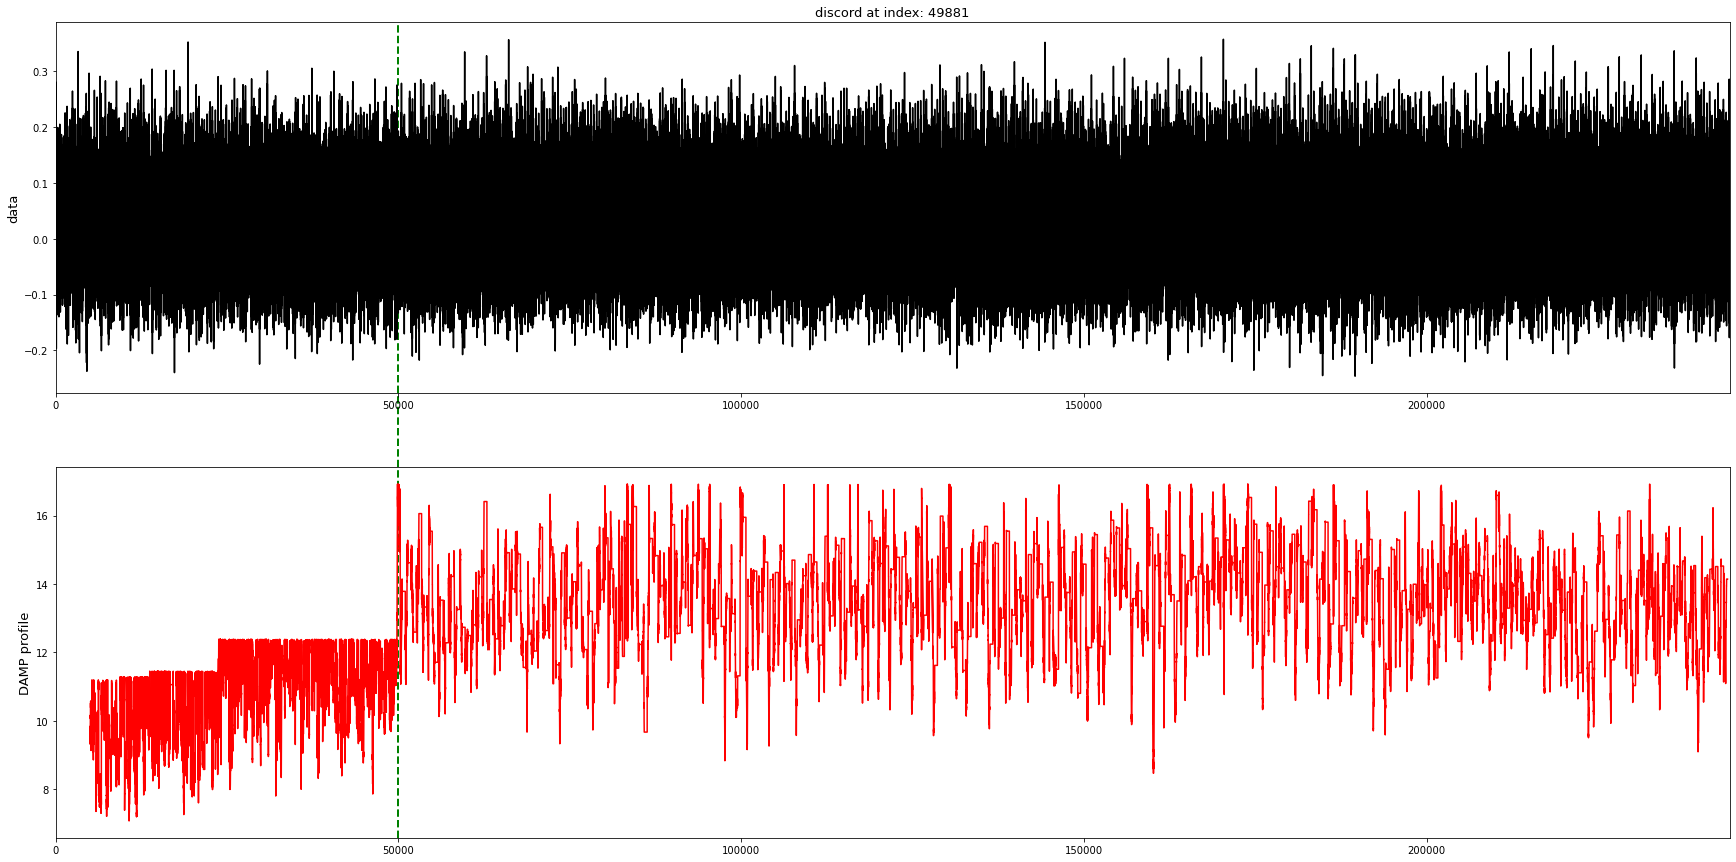

In [31]:
fig, axs = plt.subplots(nrows=2, figsize=(30, 15))

axs[0].plot(T, color='k')
axs[0].set_xlim(0, len(T))

axs[1].plot(PL, color='r')
axs[1].set_xlim(0, len(T))

axs[0].axvline(x=discord_idx,ymin=-1,ymax=1,c="g",linewidth=2, linestyle='--', zorder=0, clip_on=False)
axs[1].axvline(x=discord_idx,ymin=0,ymax=1,c="g",linewidth=2, linestyle='--', zorder=0, clip_on=False)

axs[0].set_ylabel('data', fontsize=13)
axs[1].set_ylabel('DAMP profile', fontsize=13)

axs[0].set_title(f'discord at index: {discord_idx}', fontsize=13)
plt.show()